In [10]:
# --- 1. Import Libraries ---
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# --- 2. Load and Combine Data ---

# Define the path where the CSV files are located.
# Using an uppercase variable name is a common convention for constants.
DATA_PATH = '/Users/selim/Desktop/Projects/Python Projects/Anually Sales Analysis/data/Monthly'

# Get a list of all files in the specified directory.
all_files = os.listdir(DATA_PATH)

# Initialize an empty list to hold individual dataframes.
df_list = []

# Loop through each file, read it as a DataFrame if it's a CSV, and append it to the list.
for file in all_files:
    if file.endswith('.csv'): 
        file_path = os.path.join(DATA_PATH, file)
        temp_df = pd.read_csv(file_path)
        df_list.append(temp_df)

# Concatenate all dataframes in the list into a single large dataframe.
# `ignore_index=True` creates a new index for the combined dataframe.
df = pd.concat(df_list, ignore_index=True)

In [12]:
# --- 3. Clean and Prepare Data ---

# Remove rows that act as headers within the data, then sort by date.
# This happens when multiple CSVs with headers are concatenated.
column_names = df.columns
df = df[df != column_names].sort_values('Order Date')

# Remove fully duplicate rows.
df.drop_duplicates(inplace=True)

# Drop rows where all values are missing.
df.dropna(how='all', inplace=True)

# Assign new, simplified column names directly.
df.columns = ['order_id', 'product', 'qnt', 'price_each', 'order_date', 'address']

In [13]:
# --- 4. Convert Data Types ---

# Convert columns to the correct data types for analysis and calculations.
df['order_date'] = pd.to_datetime(df['order_date'])
df['qnt'] = pd.to_numeric(df['qnt'])
df['price_each'] = pd.to_numeric(df['price_each'])

/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_15701/630001692.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['order_date'] = pd.to_datetime(df['order_date'])


In [14]:
# --- 5. Feature Engineering ---

# Split the 'address' column into separate 'street', 'city', and 'post_code' columns.
df[['street', 'city', 'post_code']] = df['address'].str.split(',', expand=True)

# Drop the original 'address' column as it's no longer needed.
df.drop(columns='address', inplace=True)

# Create a new column 'total_amount' by multiplying quantity and price.
df['total_amount'] = df['qnt'] * df['price_each']

In [15]:
# --- 6. Verify the result ---

# Display the first 5 rows to ensure everything looks correct.
print(df.head())

       order_id                   product  qnt  price_each  \
143792   147268          Wired Headphones    1       11.99   
144602   148041      USB-C Charging Cable    1       11.95   
145955   149343  Apple Airpods Headphones    1      150.00   
146609   149964    AAA Batteries (4-pack)    1        2.99   
145962   149350      USB-C Charging Cable    2       11.95   

                order_date         street            city  post_code  \
143792 2019-01-01 03:07:00      9 Lake St   New York City   NY 10001   
144602 2019-01-01 03:40:00  760 Church St   San Francisco   CA 94016   
145955 2019-01-01 04:56:00     735 5th St   New York City   NY 10001   
146609 2019-01-01 05:53:00  75 Jackson St          Dallas   TX 75001   
145962 2019-01-01 06:03:00     943 2nd St         Atlanta   GA 30301   

        total_amount  
143792         11.99  
144602         11.95  
145955        150.00  
146609          2.99  
145962         23.90  


In [16]:
# --- 7. Save the final dataframe ---

df.to_csv('/Users/selim/Desktop/Projects/Python Project/Product Sales/Final Datas/all_sales_list.csv')

OSError: Cannot save file into a non-existent directory: '/Users/selim/Desktop/Projects/Python Project/Product Sales/Final Datas'

## 1. Customer Segmentation by Purchase Behavior


### Business Question: Can we identify distinct customer segments based on their purchasing habits, and which of these segments represent our most valuable customers?


#### Required Columns: Order ID, Quantity Ordered, Price Each, Purchase Address.


In [ ]:
# --- Create a base DataFrame for this analysis ---
# Using .copy() is good practice to avoid SettingWithCopyWarning from pandas.
cst_segmentation = df[['order_id', 'qnt', 'price_each', 'city', 'post_code', 'total_amount']].copy()

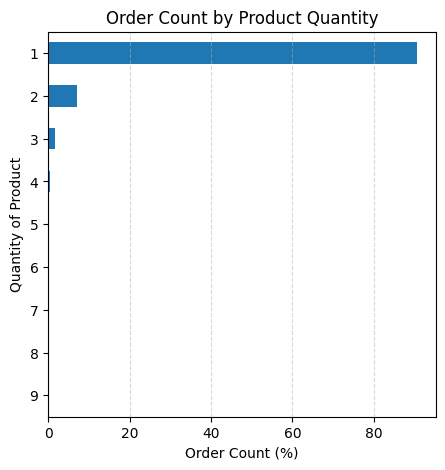

,order_id,percent
qnt,,
1,168291,90.63
2,13321,7.17
3,2920,1.57
4,806,0.43
5,236,0.13
6,80,0.04
7,24,0.01
8,5,0.00
9,3,0.00


In [ ]:
# --- 1.1 Analysis by Order Quantity ---

# Prepare a DataFrame for quantity analysis.
qnt_cst_segmentation = cst_segmentation[['qnt', 'order_id']].copy()

# Group by the quantity of items per order and count the number of orders.
qnt_cst_segmentation = qnt_cst_segmentation.groupby('qnt')[['order_id']].count()

# Calculate the percentage of total orders for each quantity.
qnt_cst_segmentation['percent'] = (qnt_cst_segmentation['order_id'] / qnt_cst_segmentation['order_id'].sum() * 100).round(2)

# --- Plot: Order Count by Product Quantity ---
qnt_cst_segmentation['percent'].iloc[::-1].plot(
    kind='barh',
    legend=False,
    figsize=(5, 5),
    title='Order Count by Product Quantity',
    xlabel='Order Count (%)',
    ylabel='Quantity of Product'
)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# Display the resulting data for review.
qnt_cst_segmentation

/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_10975/2379989851.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_each_cst_segmentation = price_each_cst_segmentation.groupby('cat')[['order_id']].count()


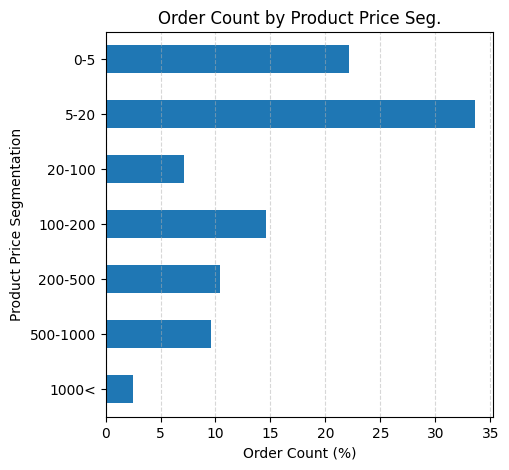

,order_id,percent
cat,,
0-5,41170,22.17
5-20,62318,33.56
20-100,13298,7.16
100-200,27121,14.61
200-500,19258,10.37
500-1000,17800,9.59
1000<,4721,2.54


In [ ]:
# --- 1.2 Analysis by Individual Product Price ---

# Define the price ranges (bins) and their labels for segmentation.
bins_price_each = [0, 5, 20, 100, 200, 500, 1000, np.inf]
labels_price_each = ['0-5', '5-20', '20-100', '100-200', '200-500', '500-1000', '1000<']

# Prepare a DataFrame for price analysis.
price_each_cst_segmentation = cst_segmentation[['price_each', 'order_id']].copy()

# Assign each order to a price category using the bins defined above.
price_each_cst_segmentation['cat'] = pd.cut(price_each_cst_segmentation['price_each'], bins=bins_price_each, labels=labels_price_each, include_lowest=True)

# Group by price category and count the number of orders.
price_each_cst_segmentation = price_each_cst_segmentation.groupby('cat')[['order_id']].count()

# Calculate the percentage of total orders for each price category.
price_each_cst_segmentation['percent'] = (price_each_cst_segmentation['order_id'] / price_each_cst_segmentation['order_id'].sum() * 100).round(2)

# --- Plot: Order Count by Product Price Segmentation ---
price_each_cst_segmentation['percent'].iloc[::-1].plot(
    kind='barh',
    legend=False,
    figsize=(5, 5),
    title='Order Count by Product Price Seg.',
    xlabel='Order Count (%)',
    ylabel='Product Price Segmentation'
)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# Display the resulting data for review.
price_each_cst_segmentation

/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_10975/3208906594.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_amount_cst_segmentation = total_amount_cst_segmentation.groupby('cat')[['order_id']].count()


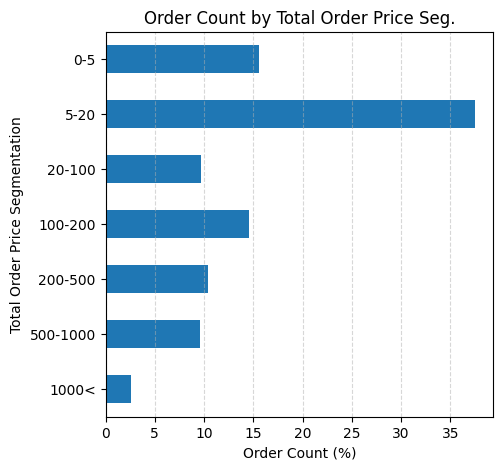

,order_id,percent
cat,,
0-5,29014,15.63
5-20,69573,37.47
20-100,18069,9.73
100-200,27067,14.58
200-500,19388,10.44
500-1000,17838,9.61
1000<,4737,2.55


In [ ]:
# --- 1.3 Analysis by Total Order Amount ---

# Note: Using the same bins and labels as the individual price analysis.
bins_total_amount = [0, 5, 20, 100, 200, 500, 1000, np.inf]
labels_total_amount = ['0-5', '5-20', '20-100', '100-200', '200-500', '500-1000', '1000<']

# Prepare a DataFrame for total amount analysis.
total_amount_cst_segmentation = cst_segmentation[['total_amount', 'order_id']].copy()

# Assign each order to a total amount category.
total_amount_cst_segmentation['cat'] = pd.cut(total_amount_cst_segmentation['total_amount'], bins=bins_total_amount, labels=labels_total_amount, include_lowest=True)

# Group by amount category and count the number of orders.
total_amount_cst_segmentation = total_amount_cst_segmentation.groupby('cat')[['order_id']].count()

# Calculate the percentage of total orders for each amount category.
total_amount_cst_segmentation['percent'] = (total_amount_cst_segmentation['order_id'] / total_amount_cst_segmentation['order_id'].sum() * 100).round(2)

# --- Plot: Order Count by Total Order Amount Segmentation ---
total_amount_cst_segmentation['percent'].iloc[::-1].plot(
    kind='barh',
    legend=False,
    figsize=(5, 5),
    title='Order Count by Total Order Price Seg.',
    xlabel='Order Count (%)',
    ylabel='Total Order Price Segmentation'
)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# Display the resulting data for review.
total_amount_cst_segmentation

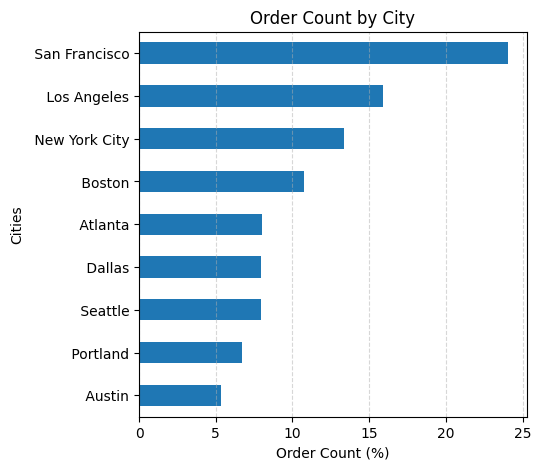

,order_id,percent
city,,
San Francisco,44662,24.05
Los Angeles,29564,15.92
New York City,24847,13.38
Boston,19901,10.72
Atlanta,14863,8.00
Dallas,14797,7.97
Seattle,14713,7.92
Portland,12449,6.70
Austin,9890,5.33


In [ ]:
# --- 1.4 Analysis by City ---

# Prepare a DataFrame for city-based analysis.
city_cst_segmentation = cst_segmentation[['city', 'order_id']].copy()

# Group by city, count orders, and sort to find cities with the most orders.
city_cst_segmentation = city_cst_segmentation.groupby('city')[['order_id']].count().sort_values('order_id', ascending=False)

# Calculate the percentage of total orders for each city.
city_cst_segmentation['percent'] = (city_cst_segmentation['order_id'] / city_cst_segmentation['order_id'].sum() * 100).round(2)

# --- Plot: Order Count by City ---
city_cst_segmentation['percent'].iloc[::-1].plot(
    kind='barh',
    legend=False,
    figsize=(5, 5),
    title='Order Count by City',
    xlabel='Order Count (%)',
    ylabel='Cities'
)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# Display the resulting data for review.
city_cst_segmentation

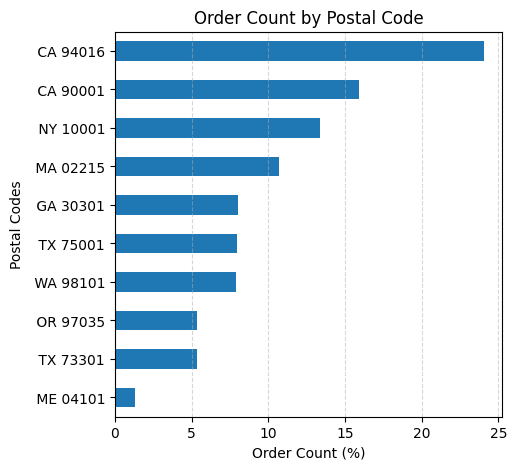

,order_id,percent
post_code,,
CA 94016,44662,24.05
CA 90001,29564,15.92
NY 10001,24847,13.38
MA 02215,19901,10.72
GA 30301,14863,8.00
TX 75001,14797,7.97
WA 98101,14713,7.92
OR 97035,9998,5.38
TX 73301,9890,5.33


In [ ]:
# --- 1.5 Analysis by Postal Code ---

# Prepare a DataFrame for postal code analysis.
post_code_cst_segmentation = cst_segmentation[['post_code', 'order_id']].copy()

# Group by postal code, count orders, and sort to find the top areas.
post_code_cst_segmentation = post_code_cst_segmentation.groupby('post_code')[['order_id']].count().sort_values('order_id', ascending=False)

# Calculate the percentage of total orders for each postal code.
post_code_cst_segmentation['percent'] = (post_code_cst_segmentation['order_id'] / post_code_cst_segmentation['order_id'].sum() * 100).round(2)

# --- Plot: Order Count by Postal Code ---
# Note: This may be hard to read if there are many unique postal codes.
post_code_cst_segmentation['percent'].iloc[::-1].plot(
    kind='barh',
    legend=False,
    figsize=(5, 5),
    title='Order Count by Postal Code',
    xlabel='Order Count (%)',
    ylabel='Postal Codes'
)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# Display the resulting data for review.
post_code_cst_segmentation

## 2. Product Bundle Analysis for Cross-Selling Opportunities


### Business Question: Which products are most frequently purchased together, and can we leverage this information to create effective product bundles and increase the average order value?


#### Required Columns: Order ID, Product.

In [ ]:
# --- 2.1 Find all product combinations within the same order ---

# Perform a self-merge to create all possible pairs of products bought in the same order.
# This results in a DataFrame where each row contains two products ('product_x', 'product_y') from the same 'order_id'.
pairs = df[['product', 'order_id']].merge(df[['product', 'order_id']], on='order_id')

# Remove pairs where a product is matched with itself.
pairs = pairs[pairs['product_x'] != pairs['product_y']]

In [ ]:
# --- 2.2 Create Canonical Pairs to Avoid Duplicates ---

# To ensure ('Product A', 'Product B') is treated the same as ('Product B', 'Product A'),
# we create a canonical representation by always putting the alphabetically smaller product name first.
pairs['p1'] = pairs[['product_x', 'product_y']].min(axis=1)
pairs['p2'] = pairs[['product_x', 'product_y']].max(axis=1)

# Now that we have canonical pairs ('p1', 'p2'), we can drop duplicate pairs within the same order.
frequent_pairs = pairs[['p1', 'p2', 'order_id']].drop_duplicates()

In [ ]:
# --- 2.3 Aggregate and Calculate Frequencies ---

# Group by the canonical pair and count how many unique orders each pair appears in.
# Then, sort to find the most frequently purchased combinations.
frequent_pairs = frequent_pairs.groupby(['p1', 'p2'])[['order_id']].count().sort_values('order_id', ascending=False)

# Calculate what percentage of total unique orders contain this pair.
# This helps to understand the combination's popularity relative to all transactions.
frequent_pairs['percent'] = (frequent_pairs['order_id'] / df['order_id'].nunique() * 100).round(2)

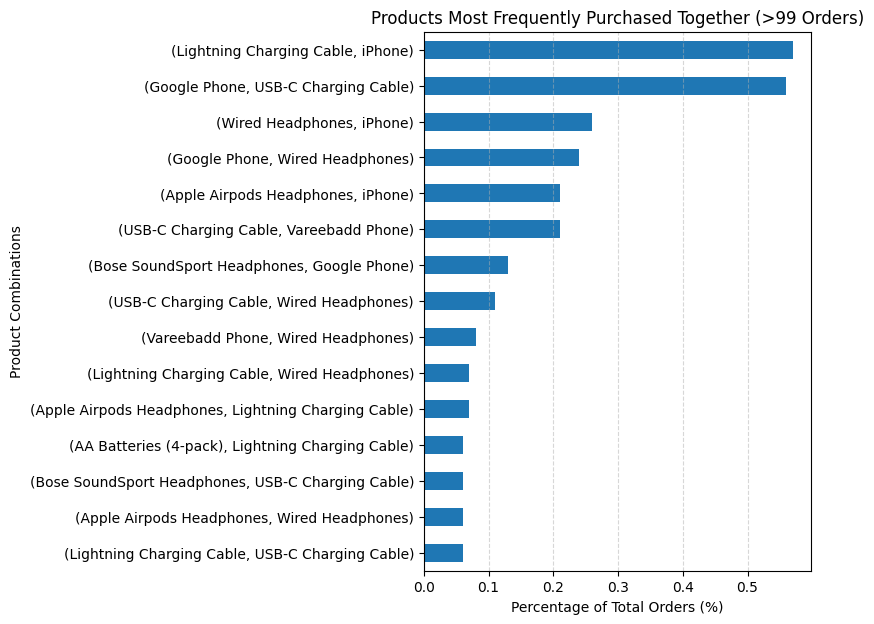

,,order_id,percent
p1,p2,,
Lightning Charging Cable,iPhone,1011,0.57
Google Phone,USB-C Charging Cable,997,0.56
Wired Headphones,iPhone,462,0.26
Google Phone,Wired Headphones,422,0.24
Apple Airpods Headphones,iPhone,373,0.21
USB-C Charging Cable,Vareebadd Phone,368,0.21
Bose SoundSport Headphones,Google Phone,228,0.13
USB-C Charging Cable,Wired Headphones,203,0.11
Vareebadd Phone,Wired Headphones,149,0.08


In [ ]:
# --- 2.4 Visualize the Most Frequent Product Bundles ---

# Filter for pairs that were bought together more than 99 times to focus the plot on the most significant combinations.
frequent_pairs = frequent_pairs[frequent_pairs['order_id'] > 99]

frequent_pairs['percent'].iloc[::-1].plot(
    kind='barh',
    legend=False,
    figsize=(5, 7),
    title='Products Most Frequently Purchased Together (>99 Orders)',
    xlabel='Percentage of Total Orders (%)',
    ylabel='Product Combinations'
)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


# --- Display the resulting data for review ---
# Show the table of frequent pairs with their counts and percentages.
frequent_pairs

## 3. Time-Based Analysis of Purchasing Patterns

### Business Question: Are there specific times of the day, days of the week, or months of the year when customers are most likely to make a purchase?


#### Required Columns: Quantity Ordered, Price Each, Order Date.


In [ ]:
# --- 3.1 Data Preparation: Extract Time-Based Features ---

# Create a dedicated DataFrame for this analysis to keep the main 'df' clean.
time_based = df[['order_id', 'order_date']].copy()

# Extract hour, day name, and month name from the 'order_date' column.
time_based['hour_of_the_day'] = time_based['order_date'].dt.hour
time_based['day_of_the_week'] = time_based['order_date'].dt.day_name()
time_based['month_of_the_year'] = time_based['order_date'].dt.month_name()

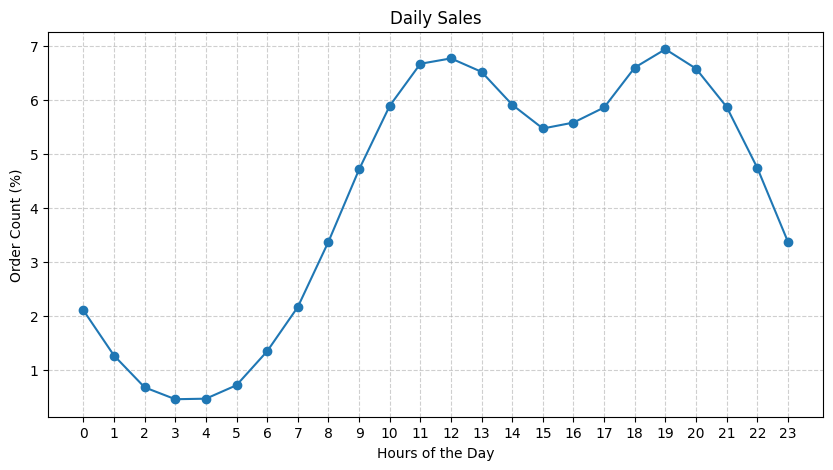

,order_id,percent
hour_of_the_day,,
0,3902,2.10
1,2347,1.26
2,1242,0.67
3,830,0.45
4,852,0.46
5,1320,0.71
6,2481,1.34
7,4002,2.16
8,6252,3.37


In [ ]:
# --- 3.2 Analysis by Hour of the Day ---

# Prepare the data for hourly analysis.
hour_of_the_day = time_based[['hour_of_the_day', 'order_id']].copy()

# Group by hour and count the number of orders.
hour_of_the_day = hour_of_the_day.groupby('hour_of_the_day')[['order_id']].count()

# Calculate the percentage of total orders for each hour.
hour_of_the_day['percent'] = (hour_of_the_day['order_id'] / hour_of_the_day['order_id'].sum() * 100).round(2)

# --- Plot: Order Count by Hour ---
# Note: A line plot is used here to show the continuous flow of sales throughout the day.
hour_of_the_day['percent'].plot(
    kind='line',
    legend=False,
    figsize=(10, 5),
    title='Daily Sales',
    xlabel='Hours of the Day',
    ylabel='Order Count (%)',
    marker='o' # Add markers to highlight each hour's data point.
)
plt.xticks(np.arange(0, 24, 1)) # Ensure all 24 hours are displayed on the x-axis.
plt.grid(True, linestyle='--', alpha=0.6) # Use a full grid for better readability.
plt.show()

# Display the resulting data for review.
hour_of_the_day

/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_10975/567684861.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  day_of_the_week = day_of_the_week.groupby('day_of_the_week')[['order_id']].count()


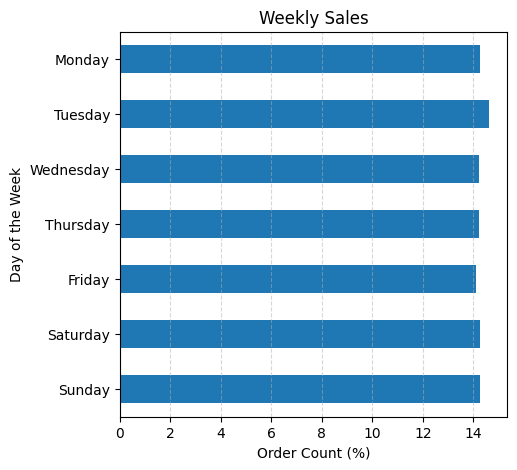

,order_id,percent
day_of_the_week,,
Monday,26508,14.28
Tuesday,27137,14.61
Wednesday,26438,14.24
Thursday,26418,14.23
Friday,26214,14.12
Saturday,26453,14.25
Sunday,26518,14.28


In [ ]:
# --- 3.3 Analysis by Day of the Week ---

# Define the correct chronological order for the days of the week.
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Prepare the data for day-of-week analysis.
day_of_the_week = time_based[['day_of_the_week', 'order_id']].copy()

# Convert the 'day_of_the_week' column to a categorical type with the specified order.
# This ensures that plots and tables are sorted correctly (e.g., Monday first).
day_of_the_week['day_of_the_week'] = pd.Categorical(day_of_the_week['day_of_the_week'], categories=weekday_order, ordered=True)

# Group by day and count the number of orders.
day_of_the_week = day_of_the_week.groupby('day_of_the_week')[['order_id']].count()

# Calculate the percentage of total orders for each day.
day_of_the_week['percent'] = (day_of_the_week['order_id'] / day_of_the_week['order_id'].sum() * 100).round(2)

# --- Plot: Order Count by Day of the Week ---
day_of_the_week['percent'].iloc[::-1].plot(
    kind='barh',
    legend=False,
    figsize=(5, 5),
    title='Weekly Sales',
    xlabel='Order Count (%)',
    ylabel='Day of the Week'
)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# Display the resulting data for review.
day_of_the_week

/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_10975/3501980537.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  month_of_the_year = month_of_the_year.groupby('month_of_the_year')[['order_id']].count()


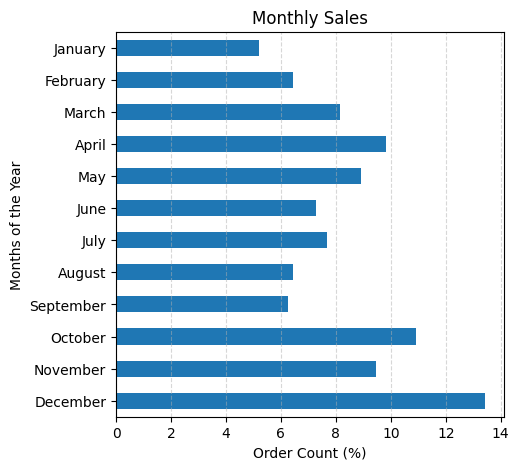

,order_id,percent
month_of_the_year,,
January,9699,5.22
February,11957,6.44
March,15128,8.15
April,18257,9.83
May,16552,8.91
June,13535,7.29
July,14275,7.69
August,11943,6.43
September,11603,6.25


In [ ]:
# --- 3.4 Analysis by Month of the Year ---

# Define the correct chronological order for the months.
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Prepare the data for month-of-year analysis.
month_of_the_year = time_based[['month_of_the_year', 'order_id']].copy()

# Convert the 'month_of_the_year' column to a categorical type with the correct order.
month_of_the_year['month_of_the_year'] = pd.Categorical(month_of_the_year['month_of_the_year'], categories=month_order, ordered=True)

# Group by month and count the number of orders.
month_of_the_year = month_of_the_year.groupby('month_of_the_year')[['order_id']].count()

# Calculate the percentage of total orders for each month.
month_of_the_year['percent'] = (month_of_the_year['order_id'] / month_of_the_year['order_id'].sum() * 100).round(2)

# --- Plot: Order Count by Month ---
month_of_the_year['percent'].iloc[::-1].plot(
    kind='barh',
    legend=False,
    figsize=(5, 5),
    title='Monthly Sales',
    xlabel='Order Count (%)',
    ylabel='Months of the Year'
)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# Display the resulting data for review.
month_of_the_year

## 4. Geographic Sales Performance Analysis


### Business Question: Which cities and states are our top-performing markets, and are there underserved regions with high growth potential?


#### Required Columns: Quantity Ordered, Price Each, Purchase Address.


In [ ]:
# --- 4.1 Data Preparation ---

# Create a base DataFrame with only the columns needed for this geographic analysis.
geo_sales_analysis = df[['order_id', 'qnt', 'total_amount', 'city', 'post_code']].copy()

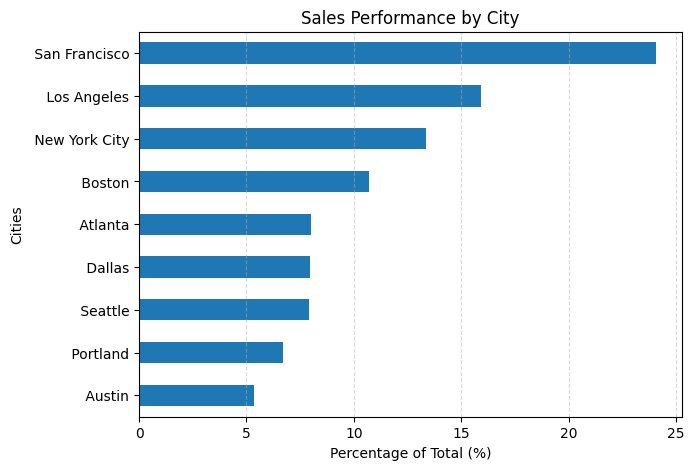

,order_count,qnt_sum,total_amount_sum,order_percent,qnt_percent,total_amount_percent
city,,,,,,
San Francisco,44662,50169,8254743.55,24.05,24.03,23.95
Los Angeles,29564,33247,5448304.28,15.92,15.92,15.81
New York City,24847,27903,4661867.14,13.38,13.36,13.53
Boston,19901,22494,3658627.65,10.72,10.77,10.62
Atlanta,14863,16584,2794199.07,8.00,7.94,8.11
Dallas,14797,16707,2765373.96,7.97,8.00,8.02
Seattle,14713,16534,2745046.02,7.92,7.92,7.96
Portland,12449,14037,2319331.94,6.70,6.72,6.73
Austin,9890,11137,1818044.33,5.33,5.33,5.27


In [ ]:
# --- 4.2 Analysis by City ---

# Group by city and aggregate key metrics.
# Using .agg() with named arguments is a clean way to calculate multiple aggregations and name the new columns simultaneously.
city_geo_sales_analysis = geo_sales_analysis.groupby('city').agg(order_count=('order_id', 'count'),qnt_sum=('qnt', 'sum'),total_amount_sum=('total_amount', 'sum'))

# Calculate the percentage contribution of each city for each metric.
city_geo_sales_analysis['order_percent'] = (city_geo_sales_analysis['order_count'] / city_geo_sales_analysis['order_count'].sum() * 100).round(2)
city_geo_sales_analysis['qnt_percent'] = (city_geo_sales_analysis['qnt_sum'] / city_geo_sales_analysis['qnt_sum'].sum() * 100).round(2)
city_geo_sales_analysis['total_amount_percent'] = (city_geo_sales_analysis['total_amount_sum'] / city_geo_sales_analysis['total_amount_sum'].sum() * 100).round(2)

# --- Plot: Geographic Performance by City ---
# We sort by 'total_amount_percent' in ascending order so the city with the highest value appears at the top of the horizontal bar chart.
city_geo_sales_analysis[['order_percent']].sort_values('order_percent', ascending=True).plot(
    kind='barh',
    figsize=(7, 5),
    legend=False,
    title='Sales Performance by City',
    xlabel='Percentage of Total (%)',
    ylabel='Cities'
)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# Display the resulting data for review, sorted by the highest total amount.
city_geo_sales_analysis.sort_values('order_percent', ascending=False)

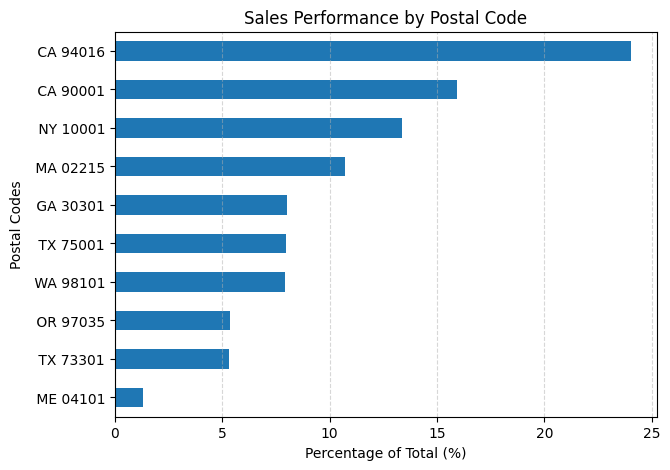

,order_count,qnt_sum,total_amount_sum,order_percent,qnt_percent,total_amount_percent
post_code,,,,,,
CA 94016,44662,50169,8254743.55,24.05,24.03,23.95
CA 90001,29564,33247,5448304.28,15.92,15.92,15.81
NY 10001,24847,27903,4661867.14,13.38,13.36,13.53
MA 02215,19901,22494,3658627.65,10.72,10.77,10.62
GA 30301,14863,16584,2794199.07,8.00,7.94,8.11
TX 75001,14797,16707,2765373.96,7.97,8.00,8.02
WA 98101,14713,16534,2745046.02,7.92,7.92,7.96
OR 97035,9998,11291,1870010.56,5.38,5.41,5.43
TX 73301,9890,11137,1818044.33,5.33,5.33,5.27


In [ ]:
# --- 4.3 Analysis by Postal Code ---

# Group by postal code and aggregate the same key metrics.
post_code_sales_analysis = geo_sales_analysis.groupby('post_code').agg(
    order_count=('order_id', 'count'),
    qnt_sum=('qnt', 'sum'),
    total_amount_sum=('total_amount', 'sum')
)

# Calculate the percentage contribution of each postal code.
post_code_sales_analysis['order_percent'] = (post_code_sales_analysis['order_count'] / post_code_sales_analysis['order_count'].sum() * 100).round(2)
post_code_sales_analysis['qnt_percent'] = (post_code_sales_analysis['qnt_sum'] / post_code_sales_analysis['qnt_sum'].sum() * 100).round(2)
post_code_sales_analysis['total_amount_percent'] = (post_code_sales_analysis['total_amount_sum'] / post_code_sales_analysis['total_amount_sum'].sum() * 100).round(2)


# --- Plot: Geographic Performance by Postal Code ---
# Note: This plot might be crowded if there are many postal codes. We could add .tail(20) to show only the top 20.
post_code_sales_analysis[['order_percent']].sort_values('order_percent', ascending=True).plot(
    kind='barh',
    figsize=(7, 5),
    legend=False,
    title='Sales Performance by Postal Code',
    xlabel='Percentage of Total (%)',
    ylabel='Postal Codes'
)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# Display the resulting data for review, sorted by the highest total amount.
post_code_sales_analysis.sort_values('order_percent', ascending=False)